# Predicting video game sales - version 1

## Project outline
The aim of this project is to predict the number of North American sales units for a collection of video games, based off other information known about them. The evaluation metric is the Mean Squared Error between the predicted sales and the actual sales of each video game.bb

## Obtaining the data
In this section, the libraries and data were imported. The data was converted into pandas dataframes in order to make analysis easier.

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [2]:
# Listing the files in the input directory
print(os.listdir("../input"))

['test.csv', 'df_sample_submission.csv', 'train.csv']


In [3]:
# Importing the train and test datasets
train_df = pd.read_csv('../input/train.csv', index_col=0) # Setting the id column as the index
test_df = pd.read_csv('../input/test.csv', index_col=0) # Setting the id column as the index

# Printing the first five lines of train_df
train_df.head()

,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Id,,,,,,,,,,,,
0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Printing the first five lines of test_df
test_df.head()

,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
Id,,,,,,,,,,,
11703,GB,1996.0,Role-Playing,Nintendo,10.22,NaN,NaN,NaN,NaN,NaN,NaN
11704,Wii,2006.0,Misc,Nintendo,2.93,58.0,41.0,6.6,129.0,Nintendo,E
11705,NES,1984.0,Shooter,Nintendo,0.28,NaN,NaN,NaN,NaN,NaN,NaN
11706,DS,2005.0,Simulation,Nintendo,1.93,NaN,NaN,NaN,NaN,NaN,NaN
11707,PS3,2013.0,Action,Take-Two Interactive,0.98,97.0,50.0,8.2,3994.0,Rockstar North,M


**Understanding the variables**

The variables in the dataset are as follows: 

* Id - A unique ID for each game in the dataset
* NA_Sales - Game sales in North America (in millions of units)
* Platform - Console on which the game is running
* Year_of_Release - Year the game was released
* Genre - Game category
* Publisher - Publisher
* JP_Sales - Game sales in Japan (in millions of units)
* Critic_Score - Aggregate score compiled by Metacritic staff
* Critic_Count - The number of critics used in coming up with the Critic_score
* User_Score - Score by Metacritic's subscribers
* User_Count - Number of users who gave the user_score
* Developer - Party responsible for creating the game
* Rating - The ESRB ratings (E.g. Everyone, Teen, Adults Only, etc.)

## Cleaning the data
In this section, the data was pre-processed. This included looking for null values, incorrect data types and multicollinearity, and taking appropriate actions.

In [5]:
# Checking the info for each column
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11703 entries, 0 to 11702
Data columns (total 12 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
Publisher          11664 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
Critic_Count       5697 non-null float64
User_Score         7011 non-null object
User_Count         5332 non-null float64
Developer          7066 non-null object
Rating             6978 non-null object
dtypes: float64(6), object(6)
memory usage: 1.2+ MB


In [6]:
# Checking for null values
train_df.isna().sum()

NA_Sales              0
Platform              0
Year_of_Release     183
Genre                 2
Publisher            39
JP_Sales              0
Critic_Score       6006
Critic_Count       6006
User_Score         4692
User_Count         6371
Developer          4637
Rating             4725
dtype: int64

Some columns contain a large number of null values, of around 50% of the total dataset. In order to build an initial version of a regression model, these columns were dropped. However, additional iterations of the model could include other options, e.g. it might be the case that the same variables are missing for the same rows, so the rows could be dropped instead of the columns as this could still potentially leave us with several thousand rows to build a model from.

In [7]:
# Dropping columns containing a large number of null values
cleaned_train_df = train_df.drop(['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'], axis=1)

Year_of_release, Genre and Publisher each have a few records with missing values. Null values in Year_of_Release were replaced with the median value (2007), as these comprise just under 2% of the data so are just about worth keeping if possible. The rows containing null values for Genre and Publisher will be dropped because they are only a very small proportion of the dataset. This is also because they are categorical, and although there is a mode category for each case this does not comprise the majority of the dataset, so there is a good chance this would be incorrect.

In [8]:
# Median Year_of_Release
cleaned_train_df.Year_of_Release.median()

2007.0

In [9]:
# Replacing missing values for Year_of_Release with the median value
cleaned_train_df.Year_of_Release.fillna(cleaned_train_df.Year_of_Release.median(), inplace=True)

In [10]:
# Value counts for Genre
cleaned_train_df.Genre.value_counts()

Action          2354
Sports          1633
Misc            1233
Role-Playing    1082
Shooter          922
Adventure        913
Racing           891
Simulation       627
Platform         592
Fighting         567
Strategy         477
Puzzle           410
Name: Genre, dtype: int64

In [11]:
# Value counts for Publisher
cleaned_train_df.Publisher.value_counts()

Electronic Arts                           943
Activision                                687
Namco Bandai Games                        664
Ubisoft                                   644
Konami Digital Entertainment              571
Nintendo                                  510
THQ                                       493
Sony Computer Entertainment               489
Sega                                      445
Take-Two Interactive                      287
Tecmo Koei                                259
Atari                                     253
Capcom                                    247
Warner Bros. Interactive Entertainment    171
Square Enix                               162
Disney Interactive Studios                148
Midway Games                              142
Microsoft Game Studios                    140
505 Games                                 139
Unknown                                   139
D3Publisher                               137
Eidos Interactive                 

In [12]:
# Dropping rows with null values for Genre or Publisher
cleaned_train_df.dropna(subset=['Genre', 'Publisher'], inplace=True)

In [13]:
# Confirming there are no null values remaining
cleaned_train_df.isna().sum()

NA_Sales           0
Platform           0
Year_of_Release    0
Genre              0
Publisher          0
JP_Sales           0
dtype: int64

In [14]:
# Checking data types
cleaned_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11662 entries, 0 to 11702
Data columns (total 6 columns):
NA_Sales           11662 non-null float64
Platform           11662 non-null object
Year_of_Release    11662 non-null float64
Genre              11662 non-null object
Publisher          11662 non-null object
JP_Sales           11662 non-null float64
dtypes: float64(3), object(3)
memory usage: 637.8+ KB


In [15]:
# Converting Year_of_Release to an integer
cleaned_train_df.Year_of_Release = cleaned_train_df.Year_of_Release.astype('int64')

Checking for multicollinearity between the continuous variables:

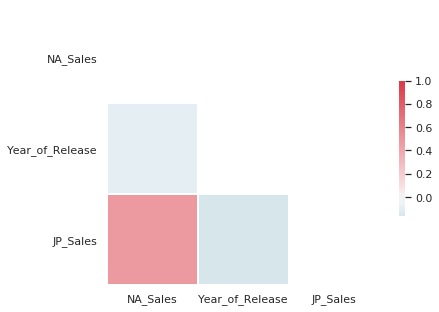

In [16]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = cleaned_train_df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (7,5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

NA_Sales and JP_Sales appear to be fairly highly correlated, but as one is the target and one is a feature this is not an issue, and so there is no problem with multicollinearity and no need to drop columns.

## Exploring the data

In this section, exploratory data analysis was conducted, as was any additional pre-processing/cleaning tasks that became apparent. 

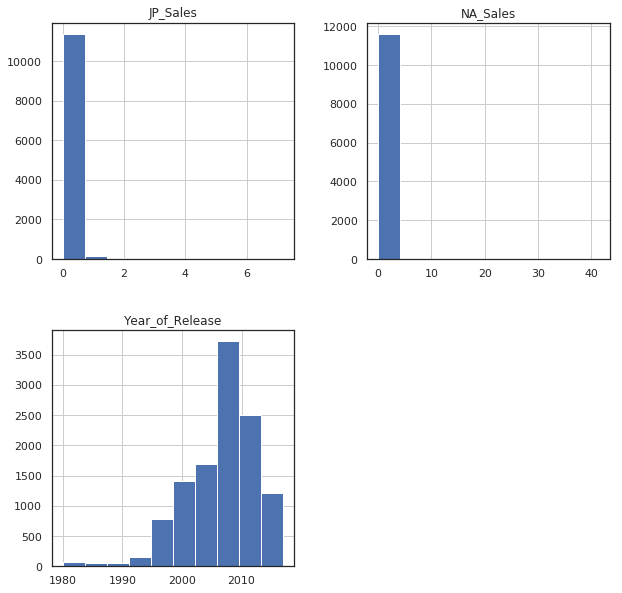

In [17]:
# Plotting histograms of the continuous variables
cleaned_train_df.hist(figsize=(10,10));

In [18]:
# Descriptive statistics for continuous variables
cleaned_train_df.describe()

,NA_Sales,Year_of_Release,JP_Sales
count,11662.000000,11662.000000,11662.000000
mean,0.267753,2006.560624,0.080456
std,0.852784,5.815110,0.319112
min,0.000000,1980.000000,0.000000
25%,0.000000,2003.000000,0.000000
50%,0.080000,2007.000000,0.000000
75%,0.240000,2010.000000,0.040000
max,41.360000,2017.000000,7.200000


The histograms above suggest that JP_Sales and NA_Sales require transformation to make them normally distributed. Log transformation would be suitable in these cases, as there are a large number of very low values and a few much larger values. However, there are a large number of zeros in the data. One possible solution is to take the square root instead of log transforming:

In [19]:
# Square root transforming JP_Sales and NA_Sales
cleaned_train_df['JP_Sales_sqrt'] = np.sqrt(cleaned_train_df.JP_Sales)
cleaned_train_df['NA_Sales_sqrt'] = np.sqrt(cleaned_train_df.NA_Sales)

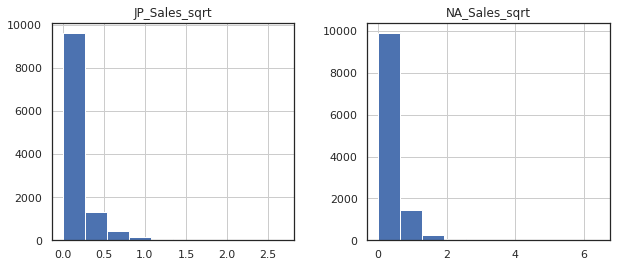

In [20]:
# Plotting histograms of the transformed continuous variables
cleaned_train_df[['JP_Sales_sqrt', 'NA_Sales_sqrt']].hist(figsize=(10,4));

Unfortunately, from the histograms above it appears that taking the square root is not a strong enough transformation to create a normally distributed distribution, so these new columns will be dropped and an alternative solution tried.

In [21]:
# Dropping the square root transformed columns
cleaned_train_df.drop(['JP_Sales_sqrt', 'NA_Sales_sqrt'], axis=1, inplace=True)

One alternative is to add a very small number to each of the zero values in the columns being transformed, so that it is possible to log transform. The number needs to be small (and smaller than any of the 'real' values) in order not to skew the results too heavily. From viewing the head of the dataset above, we can see that each sales number is to two decimal places. Therefore a value of 0.001 will be used to add to the zero values for transformation.

In [22]:
# Replacing 0 with 0.001 for JP_Sales and NA_Sales
cleaned_train_df.JP_Sales.replace({0: 0.001}, inplace=True)
cleaned_train_df.NA_Sales.replace({0: 0.001}, inplace=True)

In [23]:
# Log-transforming JP_Sales and NA_Sales
cleaned_train_df.JP_Sales = np.log(cleaned_train_df.JP_Sales)
cleaned_train_df.NA_Sales = np.log(cleaned_train_df.NA_Sales)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffb7235a358>,
      dtype=object)

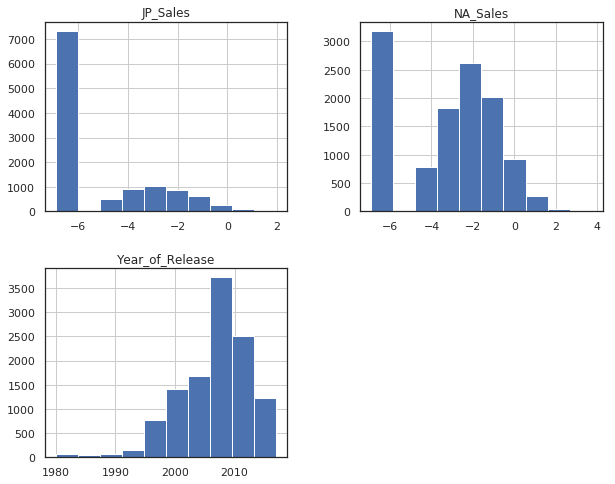

In [24]:
# Plotting histograms of the continuous variables
cleaned_train_df.hist(figsize=(10,8))

From the distributions of the transformed data above, it is now clear that JP_Sales and NA_Sales in fact have bimodal distributions, with a lot of games selling 0 (or close to 0) units, and then the rest of the sales numbers having a log-normal distribution. This is not ideal, as it means it is violating the assumptions of normality and probably also heteroscedasticity. However, these variables were left in this state in order to fit an initial regression model.



Moving on to the categorical data:

Number of unique values: 31


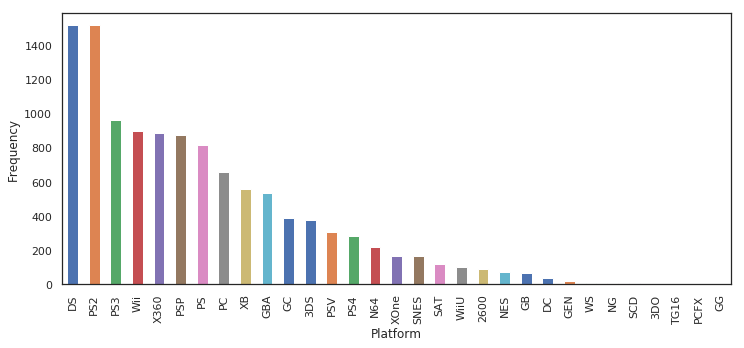

In [25]:
# Plot of value counts for each Platform
print("Number of unique values:", cleaned_train_df.Platform.nunique())
cleaned_train_df.Platform.value_counts().plot(kind='bar', figsize=(12,5))
plt.xlabel('Platform')
plt.ylabel('Frequency');

Number of unique values: 12


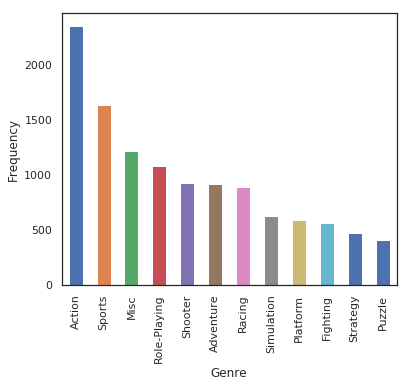

In [26]:
# Plot of value counts for each Genre
print("Number of unique values:", cleaned_train_df.Genre.nunique())
cleaned_train_df.Genre.value_counts().plot(kind='bar', figsize=(6,5))
plt.xlabel('Genre')
plt.ylabel('Frequency');

Number of unique values: 517


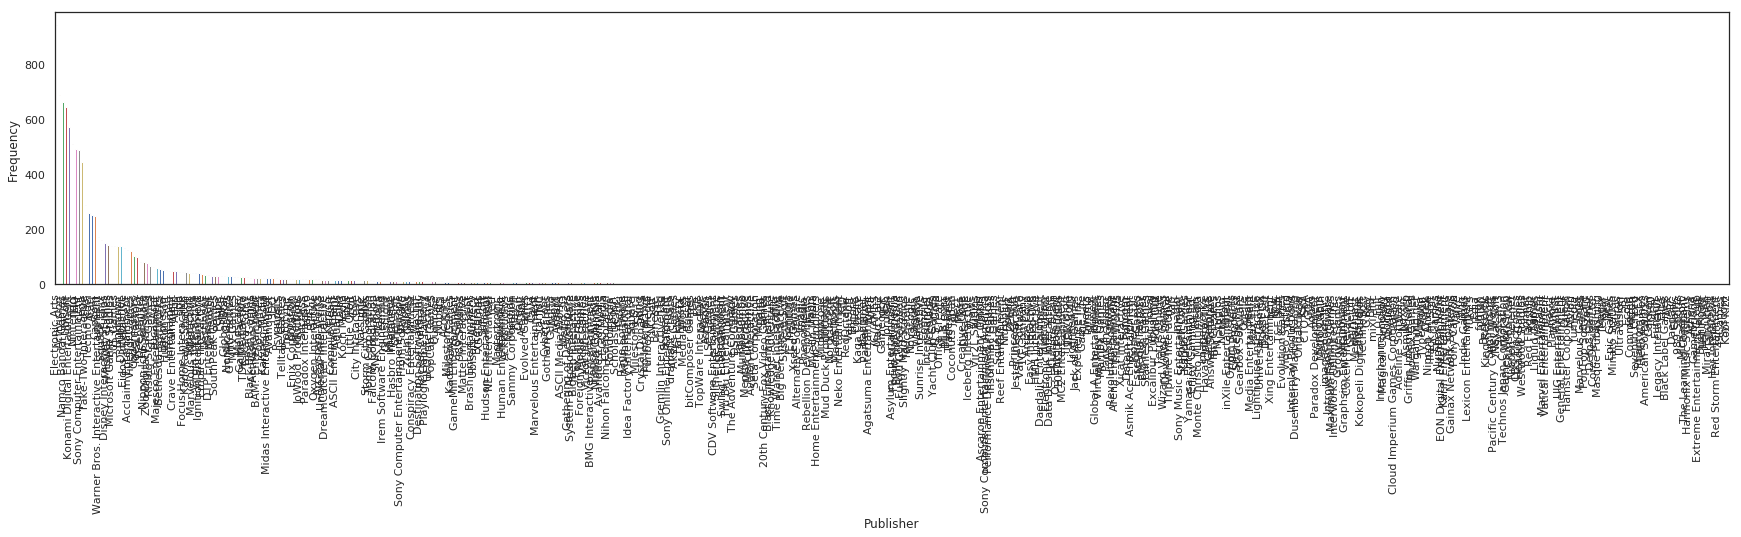

In [27]:
# Plot of value counts for each Publisher
print("Number of unique values:", cleaned_train_df.Publisher.nunique())
cleaned_train_df.Publisher.value_counts().plot(kind='bar', figsize=(30,5))
plt.xlabel('Publisher')
plt.ylabel('Frequency');

The counts and graphs above show that there are multiple categories for each variable, and there are a particularly large number of publishers. This may be an issue, as it will be necessary to one-hot encode variables to conduct regression, and this will result in too many features. For the initial version of the regression model, publisher was therefore dropped. An alternative solution to explore could have been to keep categories for the top x (e.g. 10) publishers, and group the rest into 'other'. However, this would have resulted in a very large 'other' category, which may have caused other issues.

In [28]:
# Dropping the Publisher column
cleaned_train_df.drop('Publisher', axis=1, inplace=True)

The Genre feature will be left as is (and one-hot encoded further below), as each category contains a large number of samples. However, for Platform there are quite a few categories with very small counts (see list below). As an initial attempt, categories with a count of less than 200 will be combined into 'Other':

In [29]:
# Value counts for Platform
platform_counts = cleaned_train_df.Platform.value_counts()
platform_counts

DS      1517
PS2     1517
PS3      965
Wii      897
X360     887
PSP      876
PS       819
PC       657
XB       559
GBA      534
GC       386
3DS      374
PSV      308
PS4      285
N64      219
XOne     168
SNES     165
SAT      121
WiiU     103
2600      89
NES       70
GB        65
DC        39
GEN       19
WS         6
NG         6
SCD        5
3DO        3
TG16       1
PCFX       1
GG         1
Name: Platform, dtype: int64

In [30]:
# Create a boolean column for whether a category is in the list of categories that has a count of less than 200
uncommon_platforms = cleaned_train_df.Platform.isin(platform_counts.index[platform_counts<200])
# Replace the Platform value for rows with a Platform in the uncommon_platforms list with 'Other'
cleaned_train_df.loc[uncommon_platforms, 'Platform'] = 'Other'

In [31]:
# Confirming this has worked - there are now 16 categories instead of 31
platform_cats = list(cleaned_train_df.Platform.unique())
print(cleaned_train_df.Platform.nunique())
cleaned_train_df.Platform.value_counts()

16


DS       1517
PS2      1517
PS3       965
Wii       897
X360      887
PSP       876
Other     862
PS        819
PC        657
XB        559
GBA       534
GC        386
3DS       374
PSV       308
PS4       285
N64       219
Name: Platform, dtype: int64

The categorical features can now be one-hot encoded:

In [32]:
cleaned_train_df = pd.get_dummies(cleaned_train_df)

Because Year_of_release is on a scale three orders of magnitude larger than the sales volumes, the dataset should be transformed using sklearn's standard scaler, in order to put all columns onto the same scale. However, because this results in complications for inverse transforming the predictions at the end, for an initial version features will not be scaled.

In [33]:
# Setting up X (features) and y (target)
X = cleaned_train_df.drop('NA_Sales', axis=1)
y = cleaned_train_df.NA_Sales

In [34]:
# Transforming X and y
# Ran into an error here, so scaling has been removed. Suggested version is something like:
#x_scaler = StandardScaler()
#y_scaler = StandardScaler()
#X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
#y = pd.Series(y_scaler.fit_transform(y), columns=y.columns)

# Modeling the data
This section uses multiple linear regression to attempt to use the dataset to predice North American sales values.

In [35]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)

Stepwise selection with p-values was used to select the features for the model based on their p-values. The box below defines a stepwise selection function.

In [36]:
# This function is copied from: https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [37]:
# Conducting stepwise selection on the training data
final_features = stepwise_selection(X_train, y_train)

Add  JP_Sales                       with p-value 1.61429e-165
Add  Platform_PC                    with p-value 1.91725e-125
Add  Genre_Adventure                with p-value 5.21199e-79
Add  Platform_PSP                   with p-value 1.04315e-38
Add  Platform_PSV                   with p-value 3.82121e-35
Add  Genre_Shooter                  with p-value 8.67088e-21
Add  Platform_DS                    with p-value 4.2839e-17
Add  Genre_Strategy                 with p-value 2.2911e-16
Add  Genre_Platform                 with p-value 1.71651e-14
Add  Platform_3DS                   with p-value 4.01024e-13
Add  Platform_Other                 with p-value 8.37009e-14
Add  Year_of_Release                with p-value 3.67526e-11
Add  Platform_X360                  with p-value 1.07107e-14
Add  Genre_Misc                     with p-value 8.3221e-10
Add  Platform_Wii                   with p-value 5.80674e-08
Add  Platform_PS3                   with p-value 5.15272e-05
Add  Genre_Action        

In [38]:
len(final_features)

20

A model was then built using the features selected through stepwise selection.

In [39]:
# Final model summary
predictors = sm.add_constant(X_train[final_features])
final_model = sm.OLS(y_train,predictors).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               NA_Sales   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     152.4
Date:                Fri, 22 Mar 2019   Prob (F-statistic):               0.00
Time:                        21:15:11   Log-Likelihood:                -19069.
No. Observations:                8746   AIC:                         3.818e+04
Df Residuals:                    8725   BIC:                         3.833e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             126.2086     12.104     10.427      0.000     102.482     149.935
JP_Sales           -0.2869      0.011    -25.545      0.000      -0.309      -0.265
Platform_PC        -2.3259      0.114    -20.454      0.000      -2.549      -2.103
Genre_Adventure    -1.2921      0.091    -14.186      0.000      -1.471      -1.114
Platform_PSP       -1.0049      0.101     -9.975      0.000      -1.202      -0.807
Platform_PSV       -1.4022      0.167     -8.374      0.000      -1.730      -1.074
Genre_Shooter       0.7482      0.091      8.234      0.000       0.570       0.926
Platform_DS        -0.2478      0.083     -2.981      0.003      -0.411      -0.085
Genre_Strategy     -0.9616      0.124     -7.760      0.000      -1.205      -0.719
Genre_Platform      0.8788      0.109      8.055      0.000       0.665       1.093
Platform_3DS       -0.3697      0.148     -2.496      0.013      -0.660      -0.079
Platform_Other     -0.8460      0.100     -8.433      0.000      -1.043      -0.649
Year_of_Release    -0.0652      0.006    -10.786      0.000      -0.077      -0.053
Platform_X360       0.9821      0.101      9.720      0.000       0.784       1.180
Genre_Misc         -0.3992      0.082     -4.874      0.000      -0.560      -0.239
Platform_Wii        0.6715      0.099      6.805      0.000       0.478       0.865
Platform_PS3        0.4612      0.101      4.556      0.000       0.263       0.660
Genre_Action        0.2606      0.064      4.046      0.000       0.134       0.387
Genre_Racing        0.3256      0.093      3.501      0.000       0.143       0.508
Platform_PS4        0.5240      0.170      3.087      0.002       0.191       0.857
Platform_PS        -0.3162      0.103     -3.062      0.002      -0.519      -0.114
==============================================================================
Omnibus:                       50.437   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.424
Skew:                           0.166   Prob(JB):                     1.85e-11
Kurtosis:                       2.840   Cond. No.                     1.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
final_features

['JP_Sales',
 'Platform_PC',
 'Genre_Adventure',
 'Platform_PSP',
 'Platform_PSV',
 'Genre_Shooter',
 'Platform_DS',
 'Genre_Strategy',
 'Genre_Platform',
 'Platform_3DS',
 'Platform_Other',
 'Year_of_Release',
 'Platform_X360',
 'Genre_Misc',
 'Platform_Wii',
 'Platform_PS3',
 'Genre_Action',
 'Genre_Racing',
 'Platform_PS4',
 'Platform_PS']

This model does not have a high adjusted r squared value - only 0.26. This could be caused by a wide range of issues with the pre-processing, including the fact that the target variable and one of the features were bimodally distributed, and the large number of 0s in the one-hot encoded categorical features.

Below, a multiple linear regression model is fit using the selected features, and the MSE for the train and test set calculated:

In [41]:
# Fitting a model using the selected features
linreg = LinearRegression()
linreg.fit(X_train[final_features], y_train)

# Predicting y values
y_hat_train = linreg.predict(X_train[final_features])
y_hat_test = linreg.predict(X_test[final_features])

# Calculating MSE
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

Train MSE: 4.584757364241565
Test MSE: 4.562079267625254


The train and test MSEs are similar, suggesting that over-fitting is not an issue.

# Predicting sales values for the test data

In this section, the model is used to predict sales data for the test dataset.

First, the same transformations must be applied to the test dataset:

In [42]:
# Dropping columns not used in the model
cleaned_test_df = test_df.drop(['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating', 'Publisher'], axis=1)

# Replacing 0 with 0.001 for JP_Sales
cleaned_test_df.JP_Sales.replace({0: 0.001}, inplace=True)

# Log-transforming JP_Sales
cleaned_test_df.JP_Sales = np.log(cleaned_test_df.JP_Sales)

In [43]:
# Combining the same Platform categories together as in the training set
plts = platform_cats
plts.remove('Other')

In [44]:
plts

['PSP',
 'XB',
 'X360',
 'DS',
 'PS2',
 'Wii',
 'PS3',
 '3DS',
 'PS',
 'GBA',
 'PS4',
 'PC',
 'PSV',
 'GC',
 'N64']

In [45]:
# Replace the Platform value for rows with a Platform not in the plts list with 'Other'
cleaned_test_df.loc[~cleaned_test_df['Platform'].isin(plts), 'Platform'] = 'Other'

In [46]:
cleaned_test_df.Platform.unique()

array(['Other', 'Wii', 'DS', 'PS3', 'PS2', 'X360', 'PS4', '3DS', 'N64',
       'PS', 'PC', 'GC', 'GBA', 'PSP', 'XB', 'PSV'], dtype=object)

In [47]:
# One-hot encoding categorical values
cleaned_test_df = pd.get_dummies(cleaned_test_df)

In [48]:
# Only keeping required columns
cleaned_test_df = cleaned_test_df[final_features]

The null values for Year_of_Release is an issue, because this feature is included in the model. To deal with this, the rows will null values were temporarily extracted so that they could be dealt with separately.

In [49]:
test_data_notnull = cleaned_test_df[cleaned_test_df.Year_of_Release.notnull()]

In [50]:
test_data_null = cleaned_test_df[cleaned_test_df.Year_of_Release.isna()]

Now we can predict the y values for test_data_notnull, which contains the correct columns:

In [51]:
# Predicting y values and adding them as a new column
test_data_notnull['Prediction'] = linreg.predict(test_data_notnull)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
# Creating a series with the predictions
predictions = test_data_notnull['Prediction']

In [53]:
# Converting predictions to a dataframe
predictions = pd.DataFrame(predictions)

Now it is necessary to deal with the rows with a missing Year_of_Release. For ease for an initial version, the median value of NA_Sales from the original dataset will be used for each of the predictions.

In [54]:
test_data_null['Prediction'] = cleaned_train_df.NA_Sales.median()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
test_data_null.head()

,JP_Sales,Platform_PC,Genre_Adventure,Platform_PSP,Platform_PSV,Genre_Shooter,Platform_DS,Genre_Strategy,Genre_Platform,Platform_3DS,Platform_Other,Year_of_Release,Platform_X360,Genre_Misc,Platform_Wii,Platform_PS3,Genre_Action,Genre_Racing,Platform_PS4,Platform_PS,Prediction
Id,,,,,,,,,,,,,,,,,,,,,
11884,-6.907755,0,0,0,0,1,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,-2.525729
12033,-6.907755,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,1,0,0,0,0,-2.525729
12172,-6.907755,0,0,0,0,0,0,0,0,0,0,NaN,0,0,1,0,1,0,0,0,-2.525729
12199,-6.907755,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,1,0,0,0,-2.525729
12236,-6.907755,0,0,0,0,0,0,0,0,0,0,NaN,0,1,0,0,0,0,0,0,-2.525729


In [56]:
null_predictions = test_data_null['Prediction']

In [57]:
null_predictions = pd.DataFrame(null_predictions)

In [58]:
predictions = predictions.append(null_predictions)

As a final step, the log transformation needs to be reversed.

In [59]:
predictions.Prediction = np.exp(predictions.Prediction)

In [60]:
predictions.head()

,Prediction
Id,
11703,0.004340
11704,0.009901
11705,0.056290
11706,0.007082
11707,0.013465


In [61]:
# Exporting the final predictions as a .csv
predictions.to_csv('submission.csv', index=False)

For version 2, one approach would be to segment the data into two and treat the two groups separately. Rows with null values for the columns that were dropped initially (reviews etc.) could be treated as above. And a second model could be built for rows that do contain that data, making use of the new continuous features (e.g. number of reviews, rating). Alternatively/additionally, the data could be transformed, and/or ridge or lasso regularisation could be used.